In [1]:
# unzquiezee agrega una nueva dimension que le indica el batch de procesamiento
# etapa 2: el ejemplo coje los datos crudos de la matriz (eso si esque no pide gaussiano)
# trabaja con la imagen suavizadab (S)
# magnitud con la imagen suavizada (S)
# pasar de radianes a grados
# normalizar 0-180 en theta
# etp 3: en funcion del angulo, vemo los vecinos, si es mayor a los vecinos, se queda, para hacer los bordes mas delgados
    # 0, 180 -> izquierda y derecha
    # 45 -> diagonal superior derecha e inferior izquierda
    # 90 -> arriba y abajo
    # 135 -> diagonal superior izquierda e inferior derecha
# etp4: umbral alto y bajo, si es mayor al umbral alto, se queda 
# hacer con 7x7 y calcular a mano

# Etapa 1: Suavizado gaussiano
# Etapa 2: Gradiente de Sobel
# Etapa 3: Supresión de no-máximos
# Etapa 4: Histéresis (no maximum suppression)

## Definición de espacio de entrada

In [177]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as pp

In [267]:
# Creacion del tensor
data = [
    [202., 215., 206., 200., 209., 201., 210.],
    [216., 201., 211., 212., 215., 217., 202.],
    [200., 199., 201., 206., 202., 208., 218.],
    [215., 211., 202., 219., 204., 201., 206.],
    [2., 2., 2., 2., 2., 2., 2.],
    [10., 20., 29., 40., 50., 10., 20.],
    [50., 60., 40., 90., 20., 10., 30.]
]

data = [
    [202., 215., 206., 2., 2., 2., 2.],
    [216., 201., 211., 2., 2., 2., 2.],
    [200., 199., 201., 2., 2., 2., 2.],
    [215., 211., 202., 2., 2., 2., 2.],
    [216., 216., 206., 2., 2., 2., 2.],
    [216., 216., 206., 2., 5., 1., 2.],
    [216., 216., 206., 2., 2., 1., 3.]
]

data = [
    [202., 215., 206., 206., 206., 206., 2.],
    [216., 201., 211., 206., 206., 2., 2.],
    [200., 199., 201., 206., 2., 2., 2.],
    [215., 211., 206., 2., 2., 2., 2.],
    [216., 216., 2., 2., 2., 2., 2.],
    [216., 2., 2., 2., 5., 1., 2.],
    [2., 2., 2., 2., 2., 1., 3.]
]


I = torch.tensor(data, dtype=torch.float32)
print("(7, 7)")
print(I)

# Añadir una dimensión
I = I.unsqueeze(0)
print("(7, 7) → (1, 7, 7)")
print(I)

# Añadir otra dimension
I = I.unsqueeze(0)
print("(1, 7, 7) → (1, 1, 7, 7)")
print(I)

(7, 7)
tensor([[202., 215., 206., 206., 206., 206.,   2.],
        [216., 201., 211., 206., 206.,   2.,   2.],
        [200., 199., 201., 206.,   2.,   2.,   2.],
        [215., 211., 206.,   2.,   2.,   2.,   2.],
        [216., 216.,   2.,   2.,   2.,   2.,   2.],
        [216.,   2.,   2.,   2.,   5.,   1.,   2.],
        [  2.,   2.,   2.,   2.,   2.,   1.,   3.]])
(7, 7) → (1, 7, 7)
tensor([[[202., 215., 206., 206., 206., 206.,   2.],
         [216., 201., 211., 206., 206.,   2.,   2.],
         [200., 199., 201., 206.,   2.,   2.,   2.],
         [215., 211., 206.,   2.,   2.,   2.,   2.],
         [216., 216.,   2.,   2.,   2.,   2.,   2.],
         [216.,   2.,   2.,   2.,   5.,   1.,   2.],
         [  2.,   2.,   2.,   2.,   2.,   1.,   3.]]])
(1, 7, 7) → (1, 1, 7, 7)
tensor([[[[202., 215., 206., 206., 206., 206.,   2.],
          [216., 201., 211., 206., 206.,   2.,   2.],
          [200., 199., 201., 206.,   2.,   2.,   2.],
          [215., 211., 206.,   2.,   2.,   2.,   


| Dimensión | Significado                                |
| --------- | ------------------------------------------ |
| `1`       | batch size (solo una imagen)               |
| `1`       | número de canales (grayscale = 1, RGB = 3) |
| `7`       | alto                                       |
| `7`       | ancho                                      |

[[202. 215. 206. 206. 206. 206.   2.]
 [216. 201. 211. 206. 206.   2.   2.]
 [200. 199. 201. 206.   2.   2.   2.]
 [215. 211. 206.   2.   2.   2.   2.]
 [216. 216.   2.   2.   2.   2.   2.]
 [216.   2.   2.   2.   5.   1.   2.]
 [  2.   2.   2.   2.   2.   1.   3.]]
Shape: (7, 7)


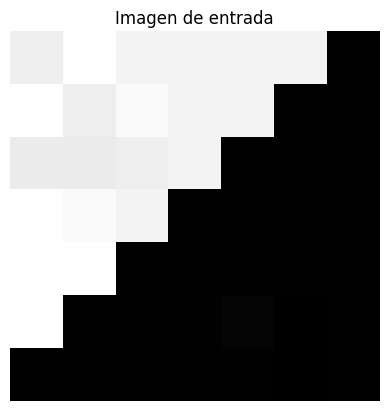

In [268]:
print("""
| Dimensión | Significado                                |
| --------- | ------------------------------------------ |
| `1`       | batch size (solo una imagen)               |
| `1`       | número de canales (grayscale = 1, RGB = 3) |
| `7`       | alto                                       |
| `7`       | ancho                                      |
""")

# Pasar el tensor a una matriz de numpy para luego poder visualizar
I_np = I.squeeze()
I_np = I_np.numpy()
print(I_np)
print(f"Shape: {I_np.shape}")

figure, axes = pp.subplots(nrows=1, ncols=1)
axes.imshow(I_np, cmap="gray")
axes.set_title("Imagen de entrada")
axes.axis("off")

pp.show()

## 1. Suavizado Gaussiano

In [269]:
# Kernel Gaussiano

K_g = torch.tensor(
    [
        [1., 2., 1.],
        [2., 4., 2.],
        [1., 2., 1.]
    ]
) / 16

print(K_g)

# Porque en PyTorch los filtros de convolución deben tener el formato:
# (out_channels, in_channels, kernel_height, kernel_width)
K_g = K_g.view(1, 1, 3, 3)
print(K_g)

tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]])
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


In [270]:
# Convolucion
S = F.conv2d(I, K_g, padding=1)
print(f"Valor Suavizado S(3,3): {S[0,0,3,3].item():.2f}")

Valor Suavizado S(3,3): 65.44


Shape de la imagen suavizada en Numpy: (7, 7)


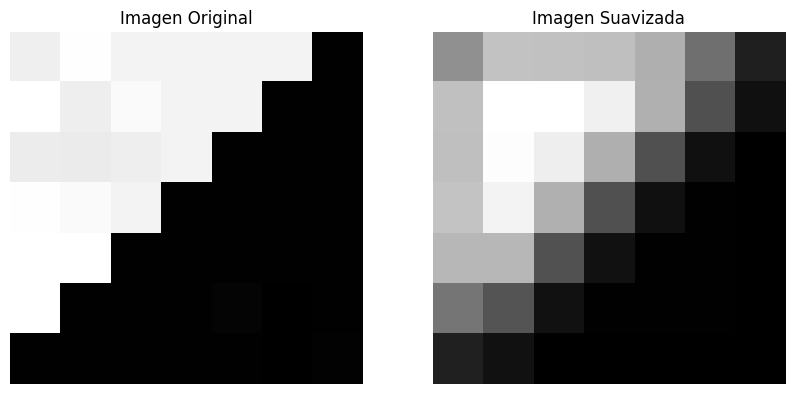

In [271]:
S_np = S.squeeze()
S_np = S_np.numpy()
print(f'Shape de la imagen suavizada en Numpy: {S_np.shape}')

# Visualizar el tensor usando la librería MatPlotLib
figure, axes = pp.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(10, 7)
axes[0].imshow(I_np, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(S_np, cmap='gray')
axes[1].set_title('Imagen Suavizada')
axes[1].axis('off')

pp.show()

## 2. Gradientes (Sobel)

In [272]:
# Son operadores Sobel, usados para medir cómo la intensidad cambia en una dirección.
# K_x	Bordes verticales
# K_y	Bordes horizontales
# Si hay un cambio fuerte de izquierda a derecha → K_x produce un valor grande.
# Si hay un cambio fuerte de arriba a abajo → K_y produce un valor grande.
# Si no hay cambio → el resultado es cercano a 0.

K_x = torch.tensor(
    [
        [-1., 0., 1.], 
        [-2., 0., 2.], 
        [-1., 0., 1.]
    ]
).view(1,1,3,3)

K_y = torch.tensor(
    [
        [-1., -2., -1.], 
        [0., 0., 0.], 
        [1., 2., 1.]
    ]
).view(1,1,3,3)

Gx = F.conv2d(S, K_x, padding=1)
Gy = F.conv2d(S, K_y, padding=1)

In [273]:
# M (Magnitud del gradiente)    Qué tan fuerte es el borde
# Si M es grande → borde fuerte
# Si M es cercano a 0 → zona uniforme (no borde)

# Θ (Theta: dirección)	        Hacia dónde apunta el borde
# atan2 devuelve el ángulo del vector gradiente en radianes, y luego lo conviertes a grados multiplicando por 180/pi:

M = torch.sqrt(Gx**2 + Gy**2)
Theta = torch.atan2(Gy, Gx) * (180 / np.pi)
Theta_raw = Theta.clone()
Theta[Theta < 0] += 180 # Normalizar [0, 180]

print(f"Magnitud M(3, 3): {M[0,0,3, 3].item():.2f}")
print(f"Ángulo Theta(3, 3): {Theta[0,0,3, 3].item():.2f}°")

print('M:', '\n', M)

Magnitud M(3, 3): 628.10
Ángulo Theta(3, 3): 44.71°
M: 
 tensor([[[[732.2114, 783.9160, 811.9052, 741.2626, 601.0291, 459.6597, 264.6046],
          [782.5297, 245.4486, 138.8000, 275.9316, 507.6594, 503.6106, 268.5294],
          [810.6368, 136.3298, 377.0681, 630.0381, 631.0934, 380.0725, 131.9967],
          [747.2723, 255.1103, 628.6678, 628.0956, 377.2415, 127.6476,  24.4401],
          [614.8720, 513.1864, 641.4792, 378.9382, 125.0785,  20.1750,   8.1877],
          [479.3867, 524.8424, 393.7711, 129.6777,  20.4408,   4.2019,   7.7075],
          [277.2592, 281.3971, 137.9484,  25.8730,   9.5970,   8.3983,   6.9827]]]])


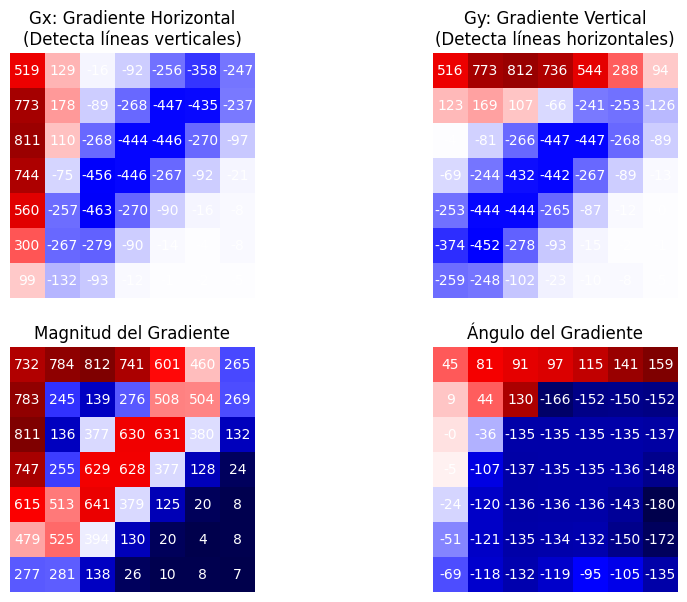

In [274]:
maxim = abs(torch.max(Gx))+100

figure, axes = pp.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(10, 7)

axes[0, 0].imshow(Gx.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 0].set_title('Gx: Gradiente Horizontal\n(Detecta líneas verticales)')
axes[0, 0].axis('off')

axes[0, 1].imshow(Gy.squeeze().numpy(), cmap='seismic', vmin=-maxim, vmax=maxim)
axes[0, 1].set_title('Gy: Gradiente Vertical\n(Detecta líneas horizontales)')
axes[0, 1].axis('off')

axes[1, 0].imshow(M.squeeze().numpy(), cmap='seismic', vmin=torch.min(M), vmax=torch.max(M))
axes[1, 0].set_title('Magnitud del Gradiente')
axes[1, 0].axis('off')


axes[1, 1].imshow(Theta_raw.squeeze().numpy(), cmap='seismic', vmin=torch.min(Theta_raw), vmax=torch.max(Theta_raw))
axes[1, 1].set_title('Ángulo del Gradiente')
axes[1, 1].axis('off')


color = None
row = 0
col = 0
for matrix in [Gx.squeeze().numpy(), Gy.squeeze().numpy(), M.squeeze().numpy(), Theta_raw.squeeze().numpy()]:
  for (j,i), label in np.ndenumerate(matrix):
    color = 'white' if abs(label) > 400 else 'black'
    axes[row, col].annotate(f"{label:.0f}", (i, j), ha='center', va='center', color='w')
  col+=1
  if (col>1):
    col = 0
    row += 1


pp.show()

## 3. Supresión de no máximos

In [275]:
def nms_step(mag, ang):
    """
    Aplica Supresión de No Máximos.
    mag: Tensor de magnitud (Batch, Channel, Height, Width)
    ang: Tensor de ángulo (Batch, Channel, Height, Width)
    """
    B, C, H, W = mag.shape
    res = torch.zeros_like(mag)

    # Quitamos dimensiones de batch/channel para iterar más fácil (suponiendo B=1, C=1)
    m = mag.squeeze()
    a = ang.squeeze()

    # Iteramos sobre los píxeles (excluyendo el borde de 1px para evitar errores de índice)
    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255.0
            r = 255.0
            angle = a[i,j].item()

            # --- Lógica de Ángulos ---
            # Ángulo 0 (Horizontal)
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = m[i, j+1]
                r = m[i, j-1]

            # Ángulo 45 (Diagonal /)
            elif (22.5 <= angle < 67.5):
                q = m[i-1, j+1] # Arriba-Derecha
                r = m[i+1, j-1] # Abajo-Izquierda

            # Ángulo 90 (Vertical)
            elif (67.5 <= angle < 112.5):
                q = m[i+1, j]   # Abajo
                r = m[i-1, j]   # Arriba

            # Ángulo 135 (Diagonal \)
            elif (112.5 <= angle < 157.5):
                q = m[i-1, j-1] # Arriba-Izquierda
                r = m[i+1, j+1] # Abajo-Derecha

            # --- Comparación y Supresión ---
            if (m[i,j] >= q) and (m[i,j] >= r):
                res[0,0,i,j] = m[i,j] # Se mantiene el valor
            else:
                res[0,0,i,j] = 0      # Se suprime

    return res

## 4. Histéresis (Umbralización con doble umbral)

Resultado después de NMS:
[[  0.        0.        0.        0.        0.        0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.     ]
 [  0.        0.      377.06805 630.0381  631.09344 380.07254   0.     ]
 [  0.        0.        0.        0.        0.        0.        0.     ]
 [  0.        0.      641.47925   0.        0.        0.        0.     ]
 [  0.        0.      393.77106   0.        0.        0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.     ]]


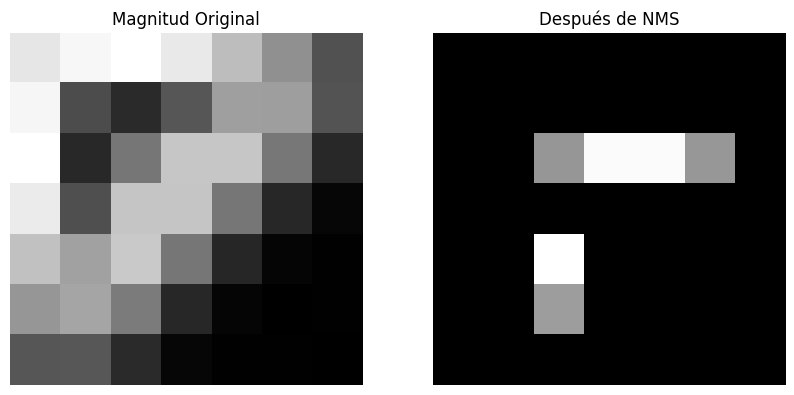

In [276]:
# Aplicar NMS primero
NMS = nms_step(M, Theta)

print("Resultado después de NMS:")
print(NMS.squeeze().numpy())

# Visualizar
figure, axes = pp.subplots(nrows=1, ncols=2)
figure.set_size_inches(10, 5)

axes[0].imshow(M.squeeze().numpy(), cmap='gray')
axes[0].set_title('Magnitud Original')
axes[0].axis('off')

axes[1].imshow(NMS.squeeze().numpy(), cmap='gray')
axes[1].set_title('Después de NMS')
axes[1].axis('off')

pp.show()

### Explicación de la Histéresis

La histéresis es el paso final del detector de Canny que decide qué bordes son "reales":

1. **Umbral Alto (`high_threshold = 150`)**: Píxeles con magnitud ≥ 150 son **bordes fuertes** → se mantienen siempre
2. **Umbral Bajo (`low_threshold = 50`)**: Píxeles con magnitud < 50 son **ruido** → se eliminan
3. **Zona intermedia [50-150]**: Son **bordes candidatos** → se mantienen SOLO si están conectados (vecinos) a un borde fuerte

**¿Por qué funciona?**
- Evita ruido: Los píxeles débiles aislados se descartan
- Preserva continuidad: Los bordes débiles que forman parte de un borde fuerte se mantienen
- Resultado: Bordes continuos y limpios

Resultado FINAL después de Histéresis:
[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 255. 255. 255. 255.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 255.   0.   0.   0.   0.]
 [  0.   0. 255.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]


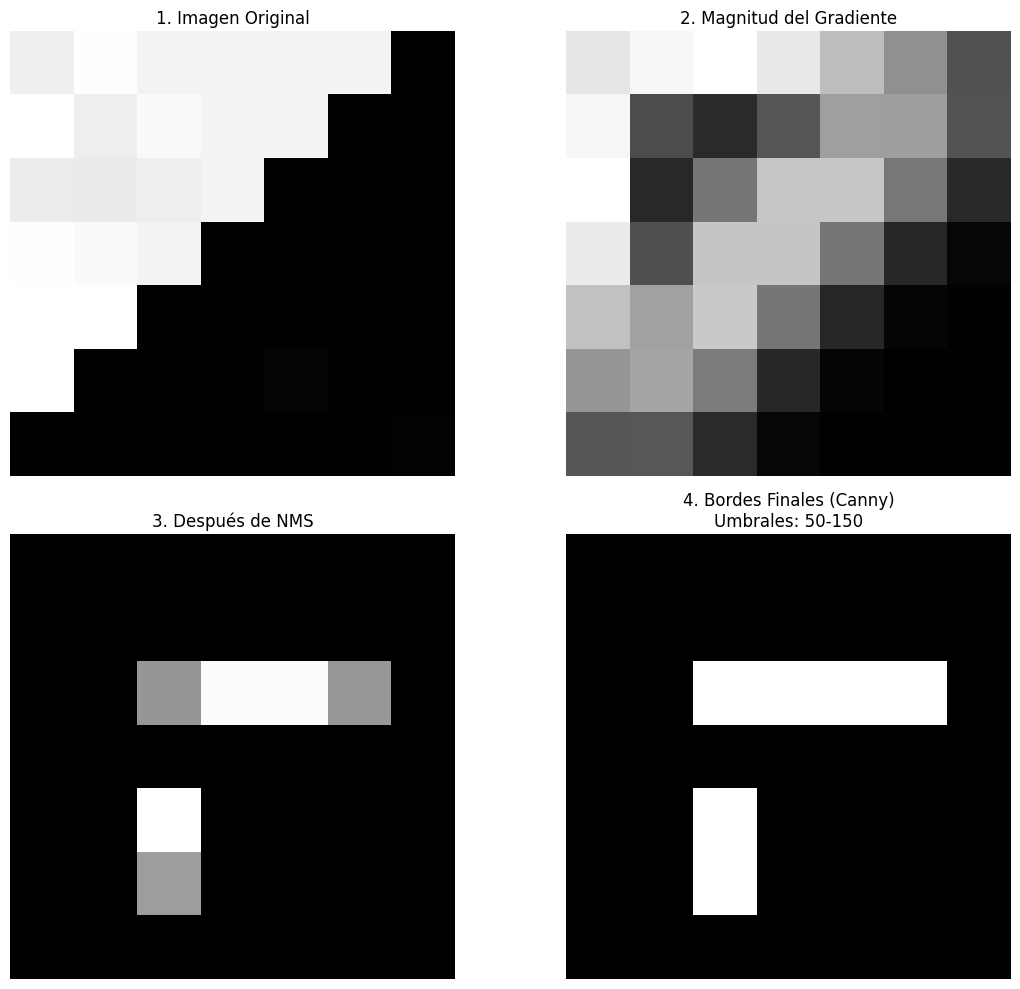

In [277]:
def hysteresis_threshold(img, low_thresh, high_thresh):
    """
    Aplica umbralización por histéresis.
    
    - Píxeles > high_thresh → Borde FUERTE (se mantiene)
    - Píxeles < low_thresh → Borde DÉBIL (se elimina)
    - low_thresh ≤ Píxeles ≤ high_thresh → Borde CANDIDATO (se mantiene solo si está conectado a un borde fuerte)
    
    img: Tensor de magnitud después de NMS (Batch, Channel, Height, Width)
    low_thresh: Umbral bajo
    high_thresh: Umbral alto
    """
    B, C, H, W = img.shape
    
    # Crear imagen de salida
    result = torch.zeros_like(img)
    
    # Valores de clasificación
    WEAK = 50
    STRONG = 255
    
    # Extraer datos
    m = img.squeeze()
    res = result.squeeze()
    
    # Paso 1: Clasificar píxeles
    strong_i, strong_j = torch.where(m >= high_thresh)
    weak_i, weak_j = torch.where((m >= low_thresh) & (m < high_thresh))
    
    # Asignar valores
    res[strong_i, strong_j] = STRONG
    res[weak_i, weak_j] = WEAK
    
    # Paso 2: Conectividad - Los píxeles débiles conectados a fuertes se convierten en fuertes
    for i in range(1, H-1):
        for j in range(1, W-1):
            if res[i, j] == WEAK:
                # Verificar los 8 vecinos
                if (res[i-1:i+2, j-1:j+2] == STRONG).any():
                    res[i, j] = STRONG
                else:
                    res[i, j] = 0  # Eliminar píxeles débiles no conectados
    
    # Actualizar el tensor original con las dimensiones correctas
    result[0, 0] = res
    
    return result

# Definir umbrales
# Para tu ejemplo con valores de magnitud en el rango ~0-230:
low_threshold = 50   # Umbral bajo
high_threshold = 150  # Umbral alto

# Aplicar histéresis
FINAL = hysteresis_threshold(NMS, low_threshold, high_threshold)

print("Resultado FINAL después de Histéresis:")
print(FINAL.squeeze().numpy())

# Visualizar todo el proceso
figure, axes = pp.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 10)

axes[0, 0].imshow(I_np, cmap='gray')
axes[0, 0].set_title('1. Imagen Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(M.squeeze().numpy(), cmap='gray')
axes[0, 1].set_title('2. Magnitud del Gradiente')
axes[0, 1].axis('off')

axes[1, 0].imshow(NMS.squeeze().numpy(), cmap='gray')
axes[1, 0].set_title('3. Después de NMS')
axes[1, 0].axis('off')

axes[1, 1].imshow(FINAL.squeeze().numpy(), cmap='gray')
axes[1, 1].set_title(f'4. Bordes Finales (Canny)\nUmbrales: {low_threshold}-{high_threshold}')
axes[1, 1].axis('off')

pp.tight_layout()
pp.show()